# 📘 Chronic Kidney Disease Prediction Using Machine Learning
Team: Dragon Tamers \
Team Coordinator: Rolfis Ramses Solano Mendez \
Team Members:
- Rolfis Ramses Solano Mendez
- Bianca-Gabriela Leoveanu
- Costa Massena

## 🎯 Objective
The goal of this project is to 3 develop machine learning models to predict the presence of Chronic Kidney Disease, or CKD shortly, based on patient data. The models implemented are:
- **Naive Bayes Classifier**, which is a probabilistic model based on Bayes' theorem.
- **Decision Tree Classifier**, which is a tree-structured model for classification tasks.
- **K-Means Clustering**, which is an unsupervised learning algorithm for clustering data.

## 1. 📥 Load CKD Dataset
We fetch the Chronic Kidney Disease dataset (ID 336) from UCI and inspect its shape and sample rows.

In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from ucimlrepo import fetch_ucirepo

## 📥 Load CKD Dataset
We fetch the Chronic Kidney Disease dataset (ID 336) from UCI and inspect its shape and sample rows.

In [ ]:
# Load dataset
def load_ckd():
  repo = fetch_ucirepo(id=336)
  feats = repo.variables.query("role=='Feature'")['name'].tolist()
  df = pd.DataFrame(repo.data.features, columns=feats)
  df['class'] = (
      pd.Series(repo.data.targets.values.flatten(), name='class')
      .astype(str)
      .str.strip()
  )
  return df

In [ ]:
df = load_ckd()
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [ ]:
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


## 2. 🧼 Data Preprocessing

We clean and prepare the dataset with the following steps:

* Drop rows with missing target labels (`class`)
* Remove duplicate entries
* Drop columns with more than 25% missing values
* Impute missing values:
  * Mean/median for numerics (based on skewness)
  * Mode for categoricals
* Scale numeric features using `StandardScaler`
* One-hot encode multiclass categorical variables
* Label encode binary categoricals and the target

### Fix unique values

In [ ]:
# Fix formatting errors
df['dm'] = df['dm'].replace('\tno', 'no')
df['class'] = df['class'].replace('ckd\t', 'ckd')

In [ ]:
df.isnull().sum()

,0
age,9
bp,12
sg,47
al,46
su,49
rbc,152
pc,65
pcc,4
ba,4
bgr,44


### Handle null values

In [ ]:
# Drop missing target rows & duplicates
df.dropna(subset=['class'], inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# Drop high-missing columns (>25%)
drop_thresh = 0.25
df = df.loc[:, df.isnull().mean() <= drop_thresh]

In [ ]:
# Identify column types
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).drop(columns=['class']).columns.tolist()

In [ ]:
for col in categorical_cols:
    print(f"Unique values in '{col}':", df[col].unique())

Unique values in 'pc': ['normal' 'abnormal' nan]
Unique values in 'pcc': ['notpresent' 'present' nan]
Unique values in 'ba': ['notpresent' 'present' nan]
Unique values in 'htn': ['yes' 'no' nan]
Unique values in 'dm': ['yes' 'no' nan]
Unique values in 'cad': ['no' 'yes' nan]
Unique values in 'appet': ['good' 'poor' nan]
Unique values in 'pe': ['no' 'yes' nan]
Unique values in 'ane': ['no' 'yes' nan]


### Impute missing values

In [ ]:
# Impute missing values
for col in numerical_cols:
  skew_val = df[col].skew()
  if -1 <= skew_val <= 1:
    df[col] = df[col].fillna(df[col].mean())
  else:
    df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
  df[col] = df[col].fillna(df[col].mode())[0]

### Encode categorical values

In [ ]:
# Label encode binary categoricals
label_mappings = {}
binary_cats = [col for col in categorical_cols if df[col].nunique() == 2]
for col in binary_cats:
  vals = df[col].dropna().unique()
  label_mappings[col] = {val: idx for idx, val in enumerate(vals)}
  df[col] = df[col].map(label_mappings[col])

In [ ]:
# One-hot encode remaining categoricals
multi_cat_cols = [col for col in categorical_cols if col not in binary_cats]
df = pd.get_dummies(df, columns = multi_cat_cols, drop_first=True)

In [ ]:
# Encode target for classification
target_encoder = LabelEncoder()
df['class'] = target_encoder.fit_transform(df['class'])

In [ ]:
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
if 'class' in categorical_cols:
    categorical_cols.remove('class')

In [ ]:
for col in categorical_cols:
    print(f"Unique values in '{col}':", df[col].unique())

In [ ]:
# Separate target
X = df.drop(columns='class')
y = df['class']

### Data scaling

In [ ]:
# Scale data for PCA, KMeans, Naive Bayes
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

### Correlation Matrix and variances

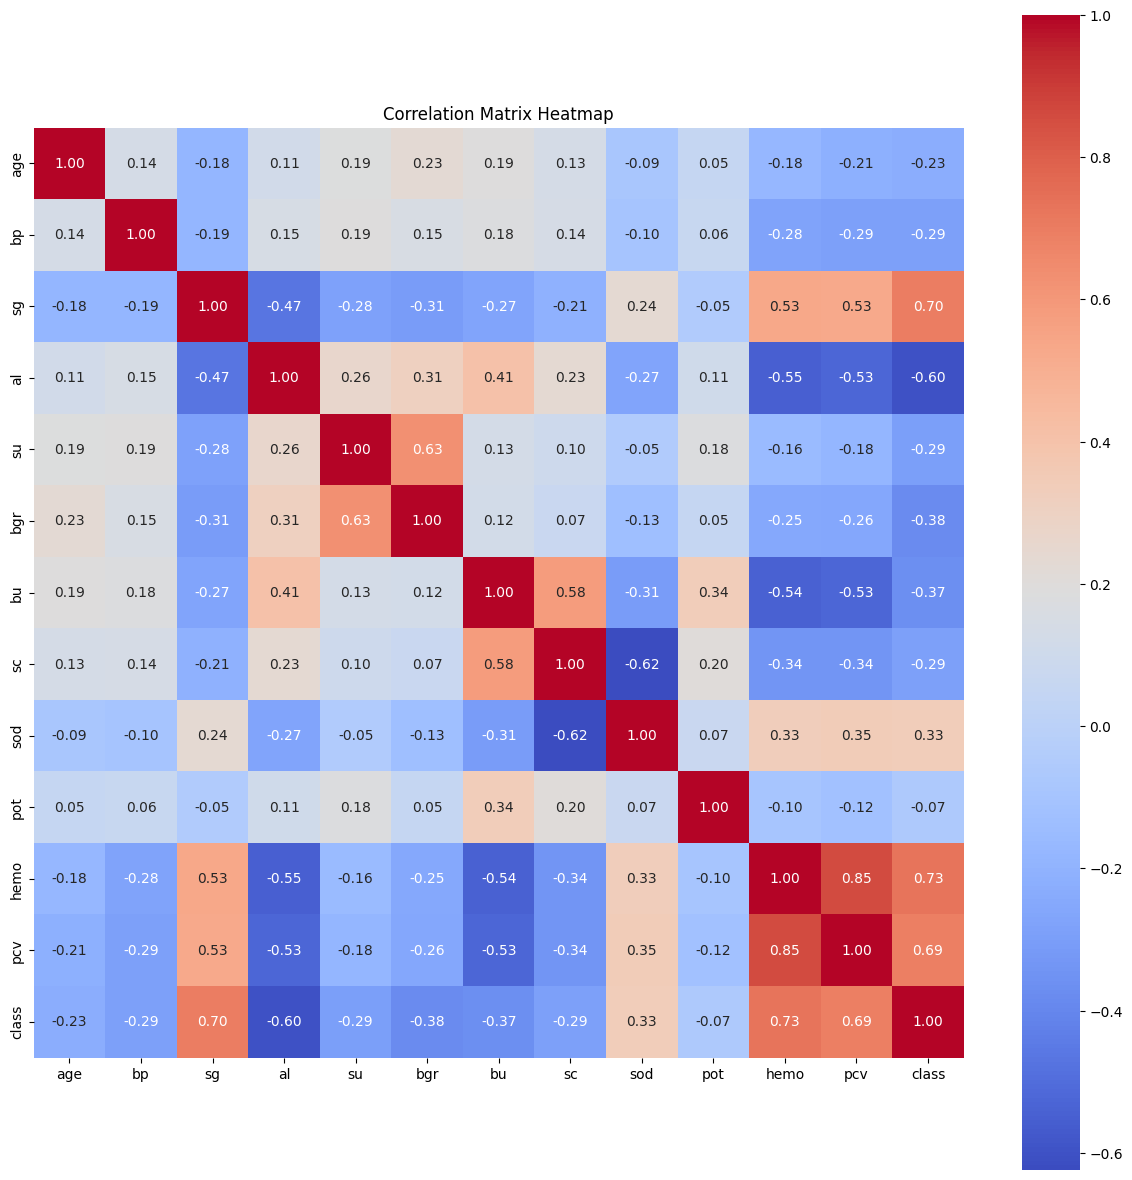

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
# Feature Variance
variances = X.var()
print("Feature Variances:\n", variances)

Feature Variances:
 age      288.149479
bp       181.974311
sg         0.000029
al         1.618793
su         1.081679
bgr     5664.184054
bu      2439.891530
sc        31.684359
sod       84.756540
pot        7.960058
hemo       7.377586
pcv       66.440128
dtype: float64


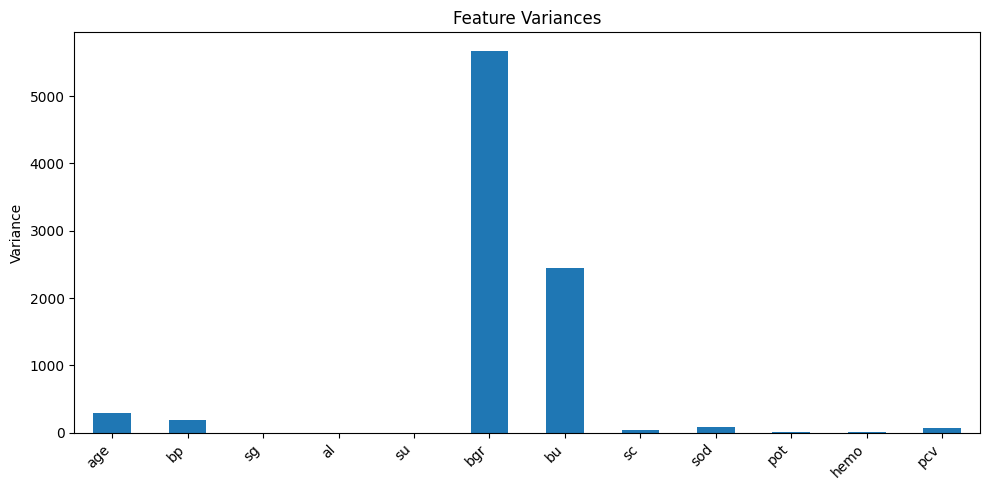

In [ ]:
variances.plot(kind='bar', figsize=(10, 5), title='Feature Variances')
plt.ylabel('Variance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Feature Selection - drop low-variance features
low_variance_cols = variances[variances < 0.01].index.tolist()
print("Dropping low variance features:", low_variance_cols)
X_selected = X.drop(columns=low_variance_cols)
X_scaled_selected = X_scaled.drop(columns=low_variance_cols)

Dropping low variance features: ['sg']


In [ ]:
# Final Outputs
print("Original X shape:", X.shape)
print("Scaled X shape:", X_scaled.shape)
print("Scaled & Selected X shape:", X_scaled_selected.shape)

Original X shape: (400, 12)
Scaled X shape: (400, 12)
Scaled & Selected X shape: (400, 11)


* For the Naive Bayes, use `X_scaled` or `X_scaled_selected`.
* For Decision Tree, use `X` or `X_selected`.
* For K-Means Clustering, use `X_scaled_selected`

## 3. 🤖 Naive Bayes Classifier
We train and evaluate a Gaussian Naive Bayes model:

* Split data into train and test sets (80/20)
* Train model on scaled features
* Predict CKD status on test set
* Evaluate with:
  * Accuracy
  * Precision
  * Recall
  * F1 Score
  * Confusion matrix


### Is the data normal distributed?

In [ ]:
X_scaled.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv
count,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,4.000000e+02
mean,5.062617e-16,-2.309264e-16,2.273737e-15,7.105427e-17,-7.105427e-17,0.000000,-1.065814e-16,7.105427e-17,6.039613e-16,-5.329071e-17,0.000000,1.776357e-16
std,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252,1.001252e+00
min,-2.918730e+00,-1.972476e+00,-2.313764e+00,-8.002896e-01,-3.802694e-01,-1.637196,-1.118774e+00,-4.619702e-01,-1.447895e+01,-7.371811e-01,-3.474833,-3.670915e+00
25%,-5.593680e-01,-4.880162e-01,-4.490180e-01,-8.002896e-01,-3.802694e-01,-0.586198,-6.018834e-01,-3.730314e-01,-2.861667e-01,-2.048563e-01,-0.608763,-5.999959e-01
50%,1.484407e-01,2.542138e-01,0.000000e+00,-1.333816e-02,-3.802694e-01,-0.320122,-2.978302e-01,-3.018804e-01,4.010412e-02,-6.290305e-02,0.000000,0.000000e+00
75%,7.382812e-01,2.542138e-01,4.833547e-01,7.736133e-01,-3.802694e-01,0.065687,1.025065e-01,-4.840492e-02,3.663749e-01,7.905023e-02,0.773586,6.283716e-01
max,2.271867e+00,7.676514e+00,1.415727e+00,3.134468e+00,4.433268e+00,4.588971,6.776474e+00,1.298557e+01,2.759027e+00,1.505512e+01,1.943975,1.856739e+00


mu: -5.329070518200751e-17, std: 0.9999999999999998


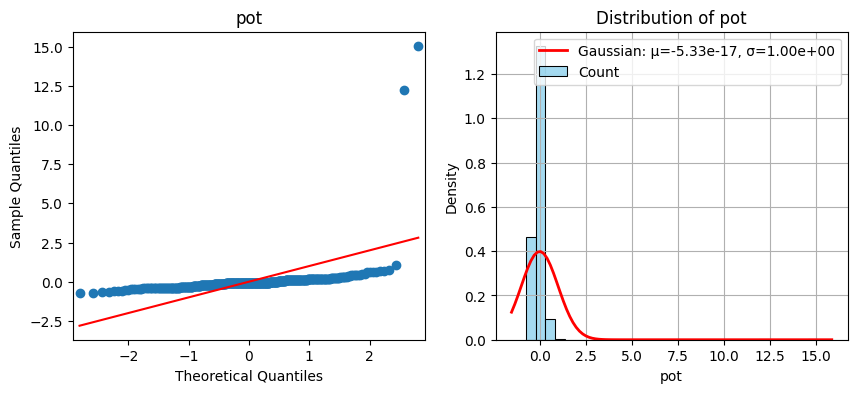

mu: 0.0, std: 1.0


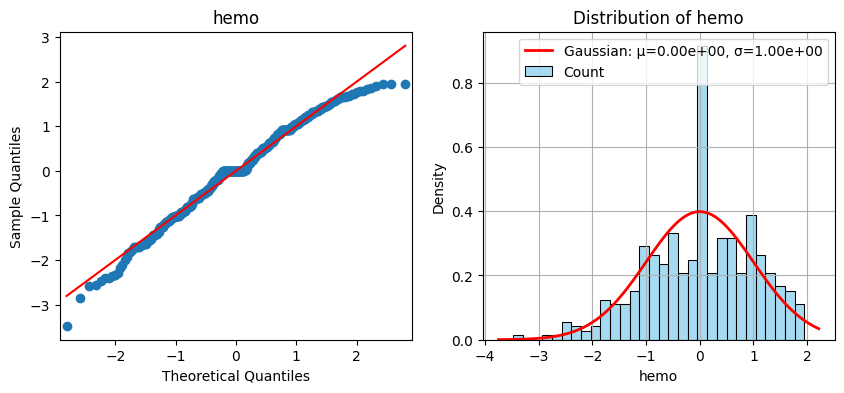

In [ ]:
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
import numpy as np
from scipy.stats import norm

cols_to_be_plot = ['pot', 'hemo']

for col in cols_to_be_plot:
  # QQ-Plot
  _, axs = plt.subplots(1, 2, figsize=(10, 4))
  axs = axs.flatten()

  qqplot(X_scaled[col], line='s', ax=axs[0])
  axs[0].set_title(col)

  # Histogram
  data = X_scaled[col].to_numpy()

  mu, std = norm.fit(data)  # fit a normal distribution
  print(f"mu: {mu}, std: {std}")
  formatted_mu = format(mu, ".2e")
  formatted_std = format(std, ".2e")
  sns.histplot(data, bins=30, kde=False, stat='density', color='skyblue', edgecolor='black', label='Count')

  # Gaussian curve
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)
  plt.plot(x, p, 'r', linewidth=2, label=f'Gaussian: μ={formatted_mu}, σ={formatted_std}')

  axs[1].set_title(f'Distribution of ' + col)
  axs[1].set_xlabel(col)
  axs[1].set_ylabel('Density')
  axs[1].legend()
  axs[1].grid(True)

  plt.show()

In [ ]:
from scipy.stats import shapiro


# Run Shapiro-Wilk test for each column
results_nd = {}
variances = []

for col in X_scaled.columns:
      data = X_scaled[col]
      stat, _ = shapiro(data)
      results_nd[col] = ({"W-statistic": stat})
      variances.append(data.var())

# Display as DataFrame
results_df = pd.DataFrame(results_nd).T
results_df['variances'] = variances
print(results_df)

      W-statistic  variances
age      0.964753   1.002506
bp       0.867299   1.002506
sg       0.905992   1.002506
al       0.775108   1.002506
su       0.433899   1.002506
bgr      0.741094   1.002506
bu       0.712249   1.002506
sc       0.389889   1.002506
sod      0.566884   1.002506
pot      0.182373   1.002506
hemo     0.984219   1.002506
pcv      0.972725   1.002506


### Baseline Model

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def log_metrics_and_confusion_matrix(y_test, y_pred, y_proba):
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Precision:", precision_score(y_test, y_pred, average='binary', zero_division=0))
  print("Recall:", recall_score(y_test, y_pred, average='binary', zero_division=0))
  print("F1 Score:", f1_score(y_test, y_pred, average='binary', zero_division=0))

  if y_proba is not None:
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
  cm = confusion_matrix(y_test,y_pred, labels=[0,1])
  dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
  dispCm.plot()

In [ ]:
def log_attributes_of_gaussian_nb(gaussianNBClassifier):
  print("Classes:", gaussianNBClassifier.classes_)
  print("Class Priors:", gaussianNBClassifier.class_prior_)
  print("Class Counts:", gaussianNBClassifier.class_count_)

Accuracy: 0.9375
Precision: 0.8484848484848485
Recall: 1.0
F1 Score: 0.9180327868852459
ROC AUC Score: 0.9945054945054945


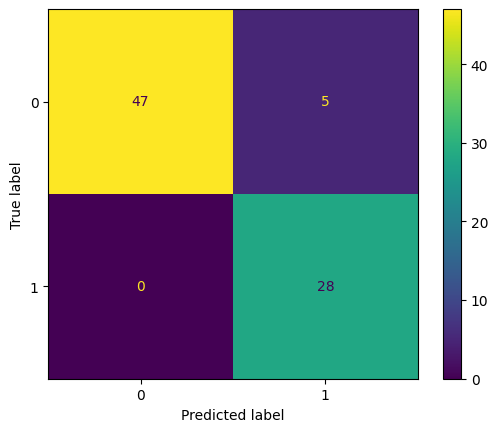

In [ ]:
# Fit data to Naive Bayes
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

gaussianNBClassifier = GaussianNB()

#test of 0.8 for training and 0.2 for test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

gaussianNBClassifier.fit(X_train, y_train)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# Predict
y_pred = gaussianNBClassifier.predict(X_test)
y_proba = gaussianNBClassifier.predict_proba(X_test)[:, 1] if hasattr(gaussianNBClassifier, "predict_proba") else None

# Metrics
log_metrics_and_confusion_matrix(y_test, y_pred, y_proba)

In [ ]:
log_attributes_of_gaussian_nb(gaussianNBClassifier)

Classes: [0 1]
Class Priors: [0.61875 0.38125]
Class Counts: [198. 122.]


In [ ]:
print("Feature Means per class:\n", gaussianNBClassifier.theta_)
print("Feature Variances per class:\n", gaussianNBClassifier.var_)

Feature Means per class:
 [[ 0.16584304  0.19048696 -0.56498102  0.45390161  0.21777608  0.33693656
   0.22936932  0.17636759 -0.26666732  0.07654096 -0.53442693 -0.48288974]
 [-0.35775854 -0.40284229  0.93765532 -0.78061033 -0.38026942 -0.47562356
  -0.47909908 -0.37740545  0.41629612 -0.07802922  0.92801187  0.87760734]]
Feature Variances per class:
 [[1.05862613e+00 1.32312003e+00 6.49015189e-01 9.85896578e-01
  1.41637843e+00 1.28423622e+00 1.36420489e+00 1.38649368e+00
  1.47085543e+00 1.95156176e+00 5.81532461e-01 6.44507462e-01]
 [8.61671651e-01 3.99151009e-01 2.34015481e-01 1.53618285e-02
  1.22844261e-09 5.70201663e-02 5.02575376e-02 2.21125894e-03
  2.82932770e-01 4.00726681e-02 2.52096082e-01 2.59778207e-01]]


### Changing params of GaussianNB

Accuracy: 0.95
Precision: 0.875
Recall: 1.0
F1 Score: 0.9333333333333333
ROC AUC Score: 0.9945054945054945


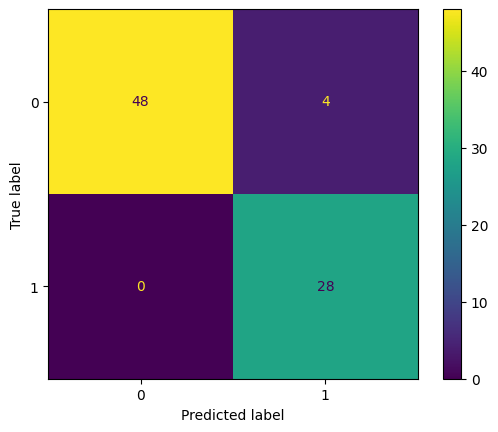

In [ ]:
gaussianNBClassifier = GaussianNB(priors=[0.86, 0.14])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

gaussianNBClassifier.fit(X_train, y_train)

# Predict
y_pred = gaussianNBClassifier.predict(X_test)
y_proba = gaussianNBClassifier.predict_proba(X_test)[:, 1] if hasattr(gaussianNBClassifier, "predict_proba") else None

log_metrics_and_confusion_matrix(y_test, y_pred, y_proba)

In [ ]:
log_attributes_of_gaussian_nb(gaussianNBClassifier)

Classes: [0 1]
Class Priors: [0.86 0.14]
Class Counts: [198. 122.]


### Cross Validation with Different Test Sizes

In [ ]:
# Use cross validation with 5-Folds
from sklearn.model_selection import cross_validate
folds = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores = {}

for fold in folds:
  scores[fold] = cross_validate(GaussianNB(),
                          X_scaled,
                          y,
                          cv=fold,
                          scoring=scoring,
                          return_train_score=True)

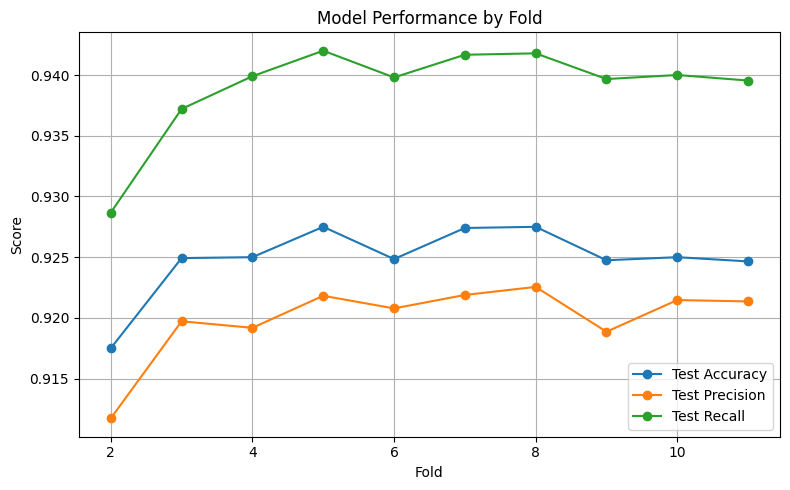

In [ ]:
# Plot the mean metrics for each fold
results_cv = []

for fold in folds:
    results_cv.append({
        "Fold": fold,
        "Test Accuracy": scores[fold]['test_accuracy'].mean(),
        "Test Precision": scores[fold]['test_precision_macro'].mean(),
        "Test Recall": scores[fold]['test_recall_macro'].mean()
    })

df_cv = pd.DataFrame(results_cv)

df_cv.plot(x='Fold', kind='line', marker='o', figsize=(8, 5))
plt.title("Model Performance by Fold")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. 🌳 Decision Tree Classifier

We will now use the decision tree algorithm.

First let's import the necessary libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from operator import index
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import tree

We will now construct make several data splits and analyse the results of the decision trees we obtain in order to choose the best test size.


In [ ]:
testsize = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]  #these are the different test sizes that we will analyse
accu_list = []
prec_list = []
rec_list = []
for i in testsize:
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=i, random_state=42)
  clf = DecisionTreeClassifier(max_depth=4, ccp_alpha=0.01)   #for now we will keep those parameters as we are just looking for the best split
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  accu_list.append(accuracy_score(y_test, y_pred))
  prec_list.append(precision_score(y_test, y_pred, average='binary', zero_division=0))
  rec_list.append(recall_score(y_test, y_pred, average='binary', zero_division=0))

print("accuracy_list: " , accu_list)
print("precision_list: " ,prec_list)
print("recall_list: " ,rec_list)



accuracy_list:  [0.95, 0.95, 0.9833333333333333, 0.9875, 0.99, 0.9916666666666667, 0.9928571428571429, 0.96875, 0.9722222222222222, 0.97, 0.9592760180995475, 0.9541666666666667, 0.9576923076923077, 0.9642857142857143]
precision_list:  [1.0, 0.9285714285714286, 0.95, 0.9655172413793104, 0.9722222222222222, 0.9777777777777777, 0.9807692307692307, 0.9206349206349206, 0.9264705882352942, 0.9459459459459459, 0.9101123595505618, 0.8969072164948454, 0.9029126213592233, 0.9174311926605505]
recall_list:  [0.8571428571428571, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9722222222222222, 0.9878048780487805, 0.9886363636363636, 0.9893617021276596, 0.9900990099009901]


The first thing we can notice is that the results are all quite close to 1, which means that the decision tree algorithm works well in our classification.

We will now determine the best possible split by calculating the mean of those 3 results lists.

In [ ]:

mean_results = []
for i in range(len(accu_list)):
  mean_results.append((accu_list[i] + prec_list[i] + rec_list[i])/3)
index = mean_results.index(max(mean_results))
print("The best test size is: ", testsize[index])

The best test size is:  0.35


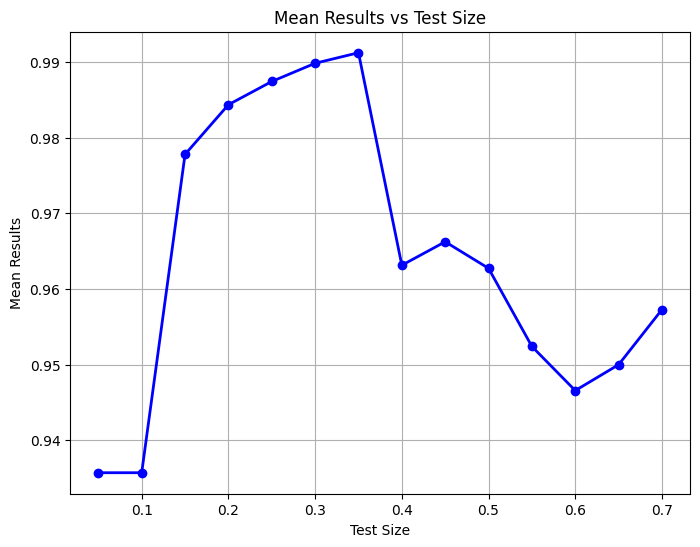

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(testsize, mean_results, 'bo-', linewidth=2, markersize=6)
plt.title('Mean Results vs Test Size')
plt.xlabel('Test Size')
plt.ylabel('Mean Results')
plt.grid(True)
plt.show()

We now know that the best test_size for the data is 35% of test data and 65% of training data.


Now let's find the best parameters to use while making our decision tree (best maximum depth and best ccp_alpha value)

The best max_depth is:  2


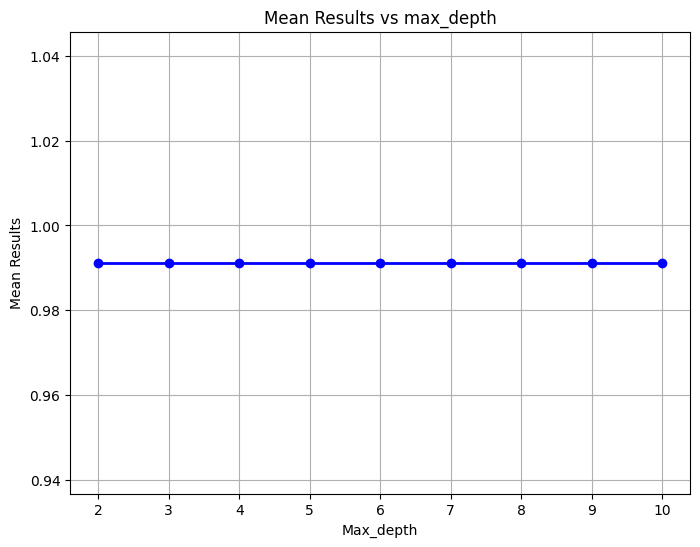

The best ccp_alpha is:  0.01


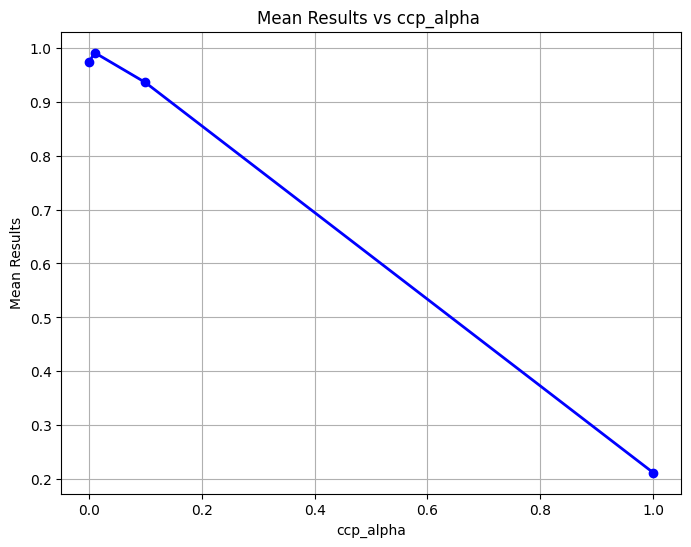

In [ ]:
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
ccp_alpha = [0.001, 0.01, 0.1, 1]
accu_list = []
prec_list = []
rec_list = []                    #first for max depth
for i in max_depth:
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.35, random_state=42)
  clf = DecisionTreeClassifier(max_depth=i, ccp_alpha=0.01)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  accu_list.append(accuracy_score(y_test, y_pred))
  prec_list.append(precision_score(y_test, y_pred, average='binary', zero_division=0))
  rec_list.append(recall_score(y_test, y_pred, average='binary', zero_division=0))

mean_results = []
for i in range(len(accu_list)):
  mean_results.append((accu_list[i] + prec_list[i] + rec_list[i])/3)
index = mean_results.index(max(mean_results))
print("The best max_depth is: ", max_depth[index])

plt.figure(figsize=(8, 6))
plt.plot(max_depth, mean_results, 'bo-', linewidth=2, markersize=6)
plt.title('Mean Results vs max_depth')
plt.xlabel('Max_depth')
plt.ylabel('Mean Results')
plt.grid(True)
plt.show()


accu_list = []
prec_list = []
rec_list = []

for i in ccp_alpha:         #now for ccp_alpha
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.35, random_state=42)
  clf = DecisionTreeClassifier(max_depth=4, ccp_alpha=i)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  accu_list.append(accuracy_score(y_test, y_pred))
  prec_list.append(precision_score(y_test, y_pred, average='binary', zero_division=0))
  rec_list.append(recall_score(y_test, y_pred, average='binary', zero_division=0))

mean_results = []
for i in range(len(accu_list)):
  mean_results.append((accu_list[i] + prec_list[i] + rec_list[i])/3)
index = mean_results.index(max(mean_results))
print("The best ccp_alpha is: ", ccp_alpha[index])

plt.figure(figsize=(8, 6))
plt.plot(ccp_alpha, mean_results, 'bo-', linewidth=2, markersize=6)
plt.title('Mean Results vs ccp_alpha ')
plt.xlabel('ccp_alpha')
plt.ylabel('Mean Results')
plt.grid(True)
plt.show()

We have found the best parameters to make our decision tree. Now let's look at the feature importances.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.35, random_state=42)
clf = DecisionTreeClassifier(max_depth=2, ccp_alpha=0.01)
clf.fit(X_train, y_train)

feature_names = X_scaled.columns
feature_importance = pd.DataFrame(clf.feature_importances_, index = feature_names).sort_values(0, ascending=False)
feature_importance

,0
hemo,0.749777
sg,0.226089
sc,0.024134
age,0.000000
al,0.000000
bp,0.000000
bgr,0.000000
su,0.000000
bu,0.000000
sod,0.000000


We can see that only 3 features actually have importance in order to classify our data: hemoglobin, specific gravity and serum creatinine.

We will remove all other features in order to avoid overfitting.

In [ ]:
X1_scaled=X_scaled.copy()
X1_scaled.drop(columns=['age', 'al', 'bp', 'bgr', 'su', 'bu', 'sod', 'pot', 'pcv' ], inplace=True)

X1_scaled.head()

,sg,sc,hemo
0,0.483355,-0.319668,1.059271
1,0.483355,-0.390819,-0.452097
2,-1.381391,-0.212942,-1.078762
3,-2.313764,0.142813,-0.488960
4,-1.381391,-0.284093,-0.341509


Now let's build our optimized decision tree based on our previous results.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1_scaled, y, test_size=0.35, random_state=42)
clf = DecisionTreeClassifier(max_depth=2, ccp_alpha=0.01)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred, average='binary', zero_division=0))
print("Recall: ", recall_score(y_test, y_pred, average='binary', zero_division=0))

Accuracy:  0.9928571428571429
Precision:  0.9807692307692307
Recall:  1.0


The results we get are excellent, let's take a look at our final tree and the confusion matrix.

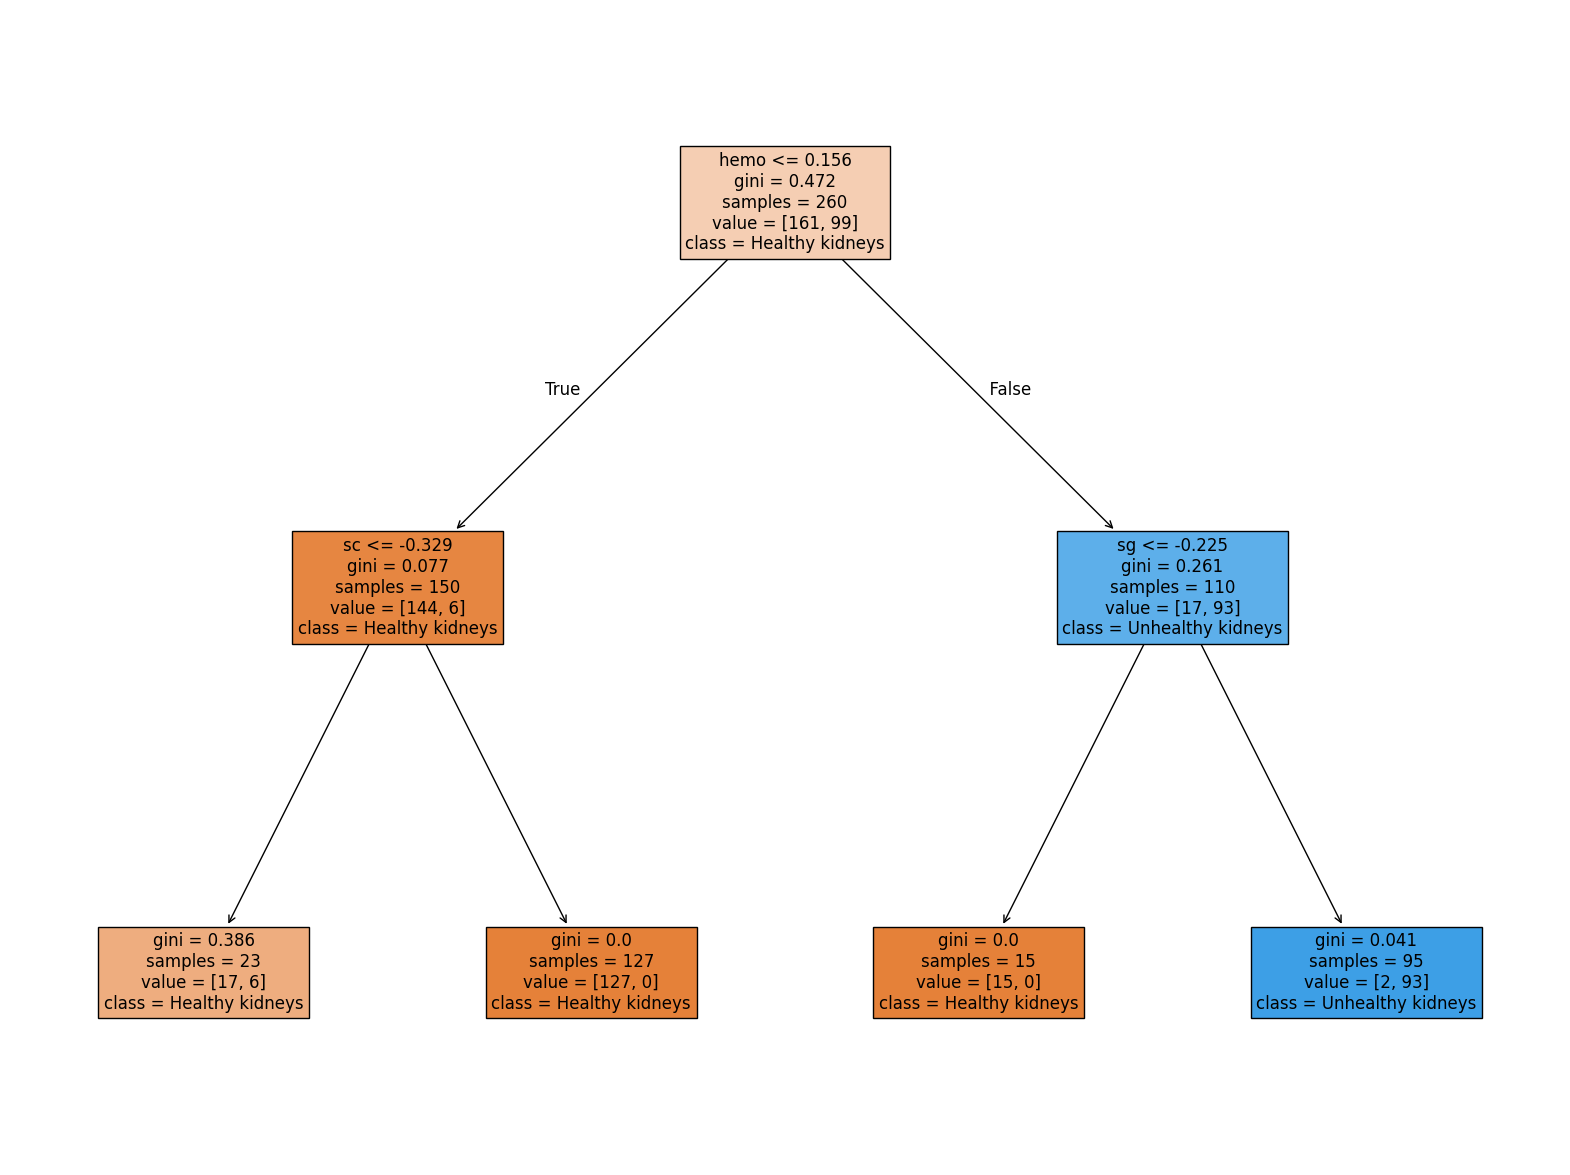

In [ ]:
featureX = X1_scaled.columns
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(clf,
                   feature_names=featureX,
                   class_names={0:'Healthy kidneys', 1:'Unhealthy kidneys'},
                   filled=True,
                  fontsize=12)

In [ ]:
y_pred
y_test

,class
209,0
280,1
33,0
210,0
93,0
...,...
194,0
229,0
265,1
218,0


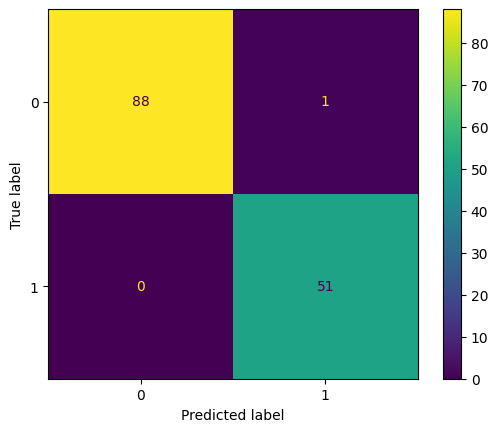

In [ ]:

cm = confusion_matrix(y_test,y_pred, labels=[0,1])
cm

dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
dispCm.plot()

The confusion matrix shows that out of 140 patients, only one was misdiagnosed, furthermore the mistake is a false positive, which is way better in the medical field than a false negative.

# Cross validation:

We will now cross validate our results, because a single train-test split might give misleading results. Cross-validation provides a more robust estimate of model performance.

In [ ]:
folds = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores = {}

for fold in folds:
  scores[fold] = cross_validate(DecisionTreeClassifier(max_depth=2, ccp_alpha=0.01),
                          X1_scaled,
                          y,
                          cv=fold,
                          scoring=scoring,
                          return_train_score=True)

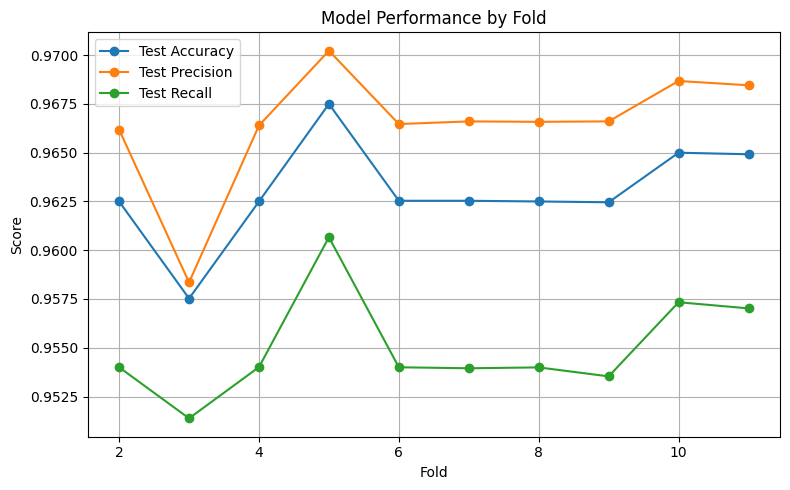

In [ ]:
results_cv = []

for fold in folds:
    results_cv.append({
        "Fold": fold,
        "Test Accuracy": scores[fold]['test_accuracy'].mean(),
        "Test Precision": scores[fold]['test_precision_macro'].mean(),
        "Test Recall": scores[fold]['test_recall_macro'].mean()
    })

df_cv = pd.DataFrame(results_cv)

df_cv.plot(x='Fold', kind='line', marker='o', figsize=(8, 5))
plt.title("Model Performance by Fold")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()

The cross validation shows that precision, recall, and accuracy all stay above 95%, which is perfectly acceptable for our classification.

**Conclusion:** The decision tree model seems perfectly adapted for our classification problem, as the results (accuracy, precision and recall) are all close to 100%, and stay above 95% no matter the number of folds.

## 5. 📊 K-Means Clustering
We apply K-Means to discover structure in the data:

* Use scaled and feature-selected dataset
* Test cluster counts (k) from 2 to 10
* Evaluate clusters using:
  * Elbow method (inertia)
  * Silhouette score
* Select optimal k based on silhouette
* Fit final model with chosen k
* Evaluate using:
  * Adjusted Rand Index (ARI)
  * Purity
  * Cluster vs true class heatmap

### 🔍 Choosing Optimal k for Clustering

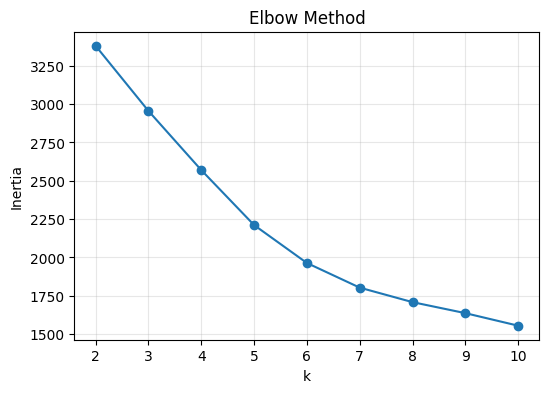

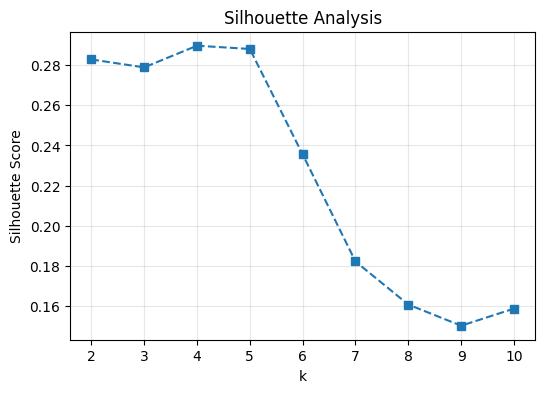

Optimal k by silhouette score: 4


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
ks = range(2, 11)
inertias, sil_scores = [], []

for k in ks:
    km = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=300)
    lbl = km.fit_predict(X_scaled_selected)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled_selected, lbl))

# Plot Elbow
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, 'o-', markersize=6)
plt.title('Elbow Method')
plt.xlabel('k'); plt.ylabel('Inertia')
plt.grid(alpha=0.3)
plt.show()

# Plot Silhouette
plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, 's--', markersize=6)
plt.title('Silhouette Analysis')
plt.xlabel('k'); plt.ylabel('Silhouette Score')
plt.grid(alpha=0.3)
plt.show()

best_k = ks[int(np.argmax(sil_scores))]
print(f"Optimal k by silhouette score: {best_k}")

### ✅ Final Clustering and Evaluation

In [ ]:
k = 4
km_final = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=300).fit(X_scaled_selected)
labels = km_final.labels_

# Append cluster label as a feature (optional)
X_scaled_selected['cluster_label'] = labels

# Compute metrics
ari = adjusted_rand_score(y, labels)
ct  = pd.crosstab(labels, y)
purity = ct.max(axis=1).sum() / ct.values.sum()

print(f"Results for k={k}:")
print(f"  Adjusted Rand Index: {ari:.3f}")
print(f"  Purity:              {purity:.3f}\n")

print("Cluster sizes:")
print(pd.Series(labels).value_counts().sort_index(), "\n")

print("Cluster vs True Class:")
print(ct)

Results for k=4:
  Adjusted Rand Index: 0.280
  Purity:              0.830

Cluster sizes:
0    218
1    135
2     45
3      2
Name: count, dtype: int64 

Cluster vs True Class:
class    0    1
row_0          
0       68  150
1      135    0
2       45    0
3        2    0


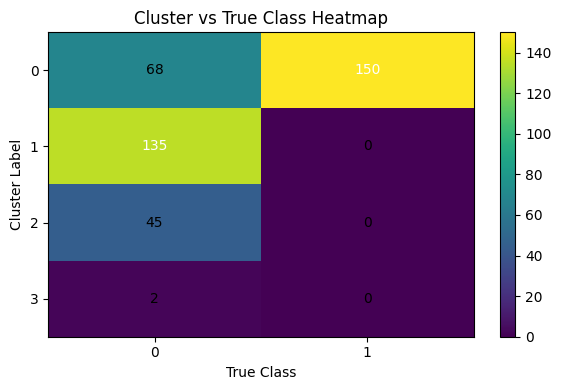

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
im = ax.imshow(ct.values, aspect='auto', cmap='viridis')

# Labels
ax.set_xticks(np.arange(ct.shape[1])); ax.set_xticklabels(ct.columns)
ax.set_yticks(np.arange(ct.shape[0])); ax.set_yticklabels(ct.index)

# Annotate
for i in range(ct.shape[0]):
    for j in range(ct.shape[1]):
        color = 'white' if ct.values[i,j] > ct.values.max()/2 else 'black'
        ax.text(j, i, ct.values[i,j], ha='center', va='center', color=color)
ax.set_xlabel('True Class'); ax.set_ylabel('Cluster Label')
ax.set_title('Cluster vs True Class Heatmap')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig('ckd_kmeans_heatmap.png', dpi=150)
plt.show()